In [3]:
from IPython.display import Image

### Kalibracja kamery

Kalibracja kamery to proces określenia jej parametrów wewnętrznych i zewnętrznych, które pozwalają na dokładne odwzorowanie trójwymiarowych punktów sceny na dwuwymiarową płaszczyznę obrazu. Jets to kluczowych etap podczas pracy z danymi z czujników, gdyż pozwala skorygować zniekształcenia optyczne a także określić relacje przestrzenne kamery i układu odniesienia świata. 

Estymowane parametry kamery można podzielić na dwie grupy:
- parametry wewnętrzne (intrinsic parameters) K - opisują właściwości optyki i matrycy kamery
    - ogniskowa fx i fy (focal length)
    - punktu główny cx i cy (optical center)
    - współczynnik ukośności piksela s (screw ratio)
    - współczynniki dystorsji optycznej: k1,k2, p1, p2, k3
- parametry zewnętrzne (extrinsic parameters) W - określają pozycje i orientację kamery w przestrzenii
    - macierz rotacji R
    - wektor translacji T


Celem kalibracji jest zatem wyznaczenie wartości 11 nieznanych parametrów: 6 parametrów zewnętrznych (3 kąty z macierzy rotacji, 3 przesunięcia z wektora translacji) oraz 5 parametry wewnętrzne (fx,fy,cx,cy, s). Jednakże parametry wewnętrznie pozostają niezmienne pomiędzy różnymi widokami tej samej sceny z różnych kątów. 

W wyniku kalkulacji każdy widok ustala 8 parametrów: 6 zmiennych parametrów zewnętrznych (rotacja i translacja) oraz 2 dodatkowe, których następnie używamy do rozwiązania macierzy parametrów wewnętrznych. A więc potrzebujemy co najmniej 3 zdjęć aby móc obliczyć wartości wszystkich 11 nieznanych parametrów.


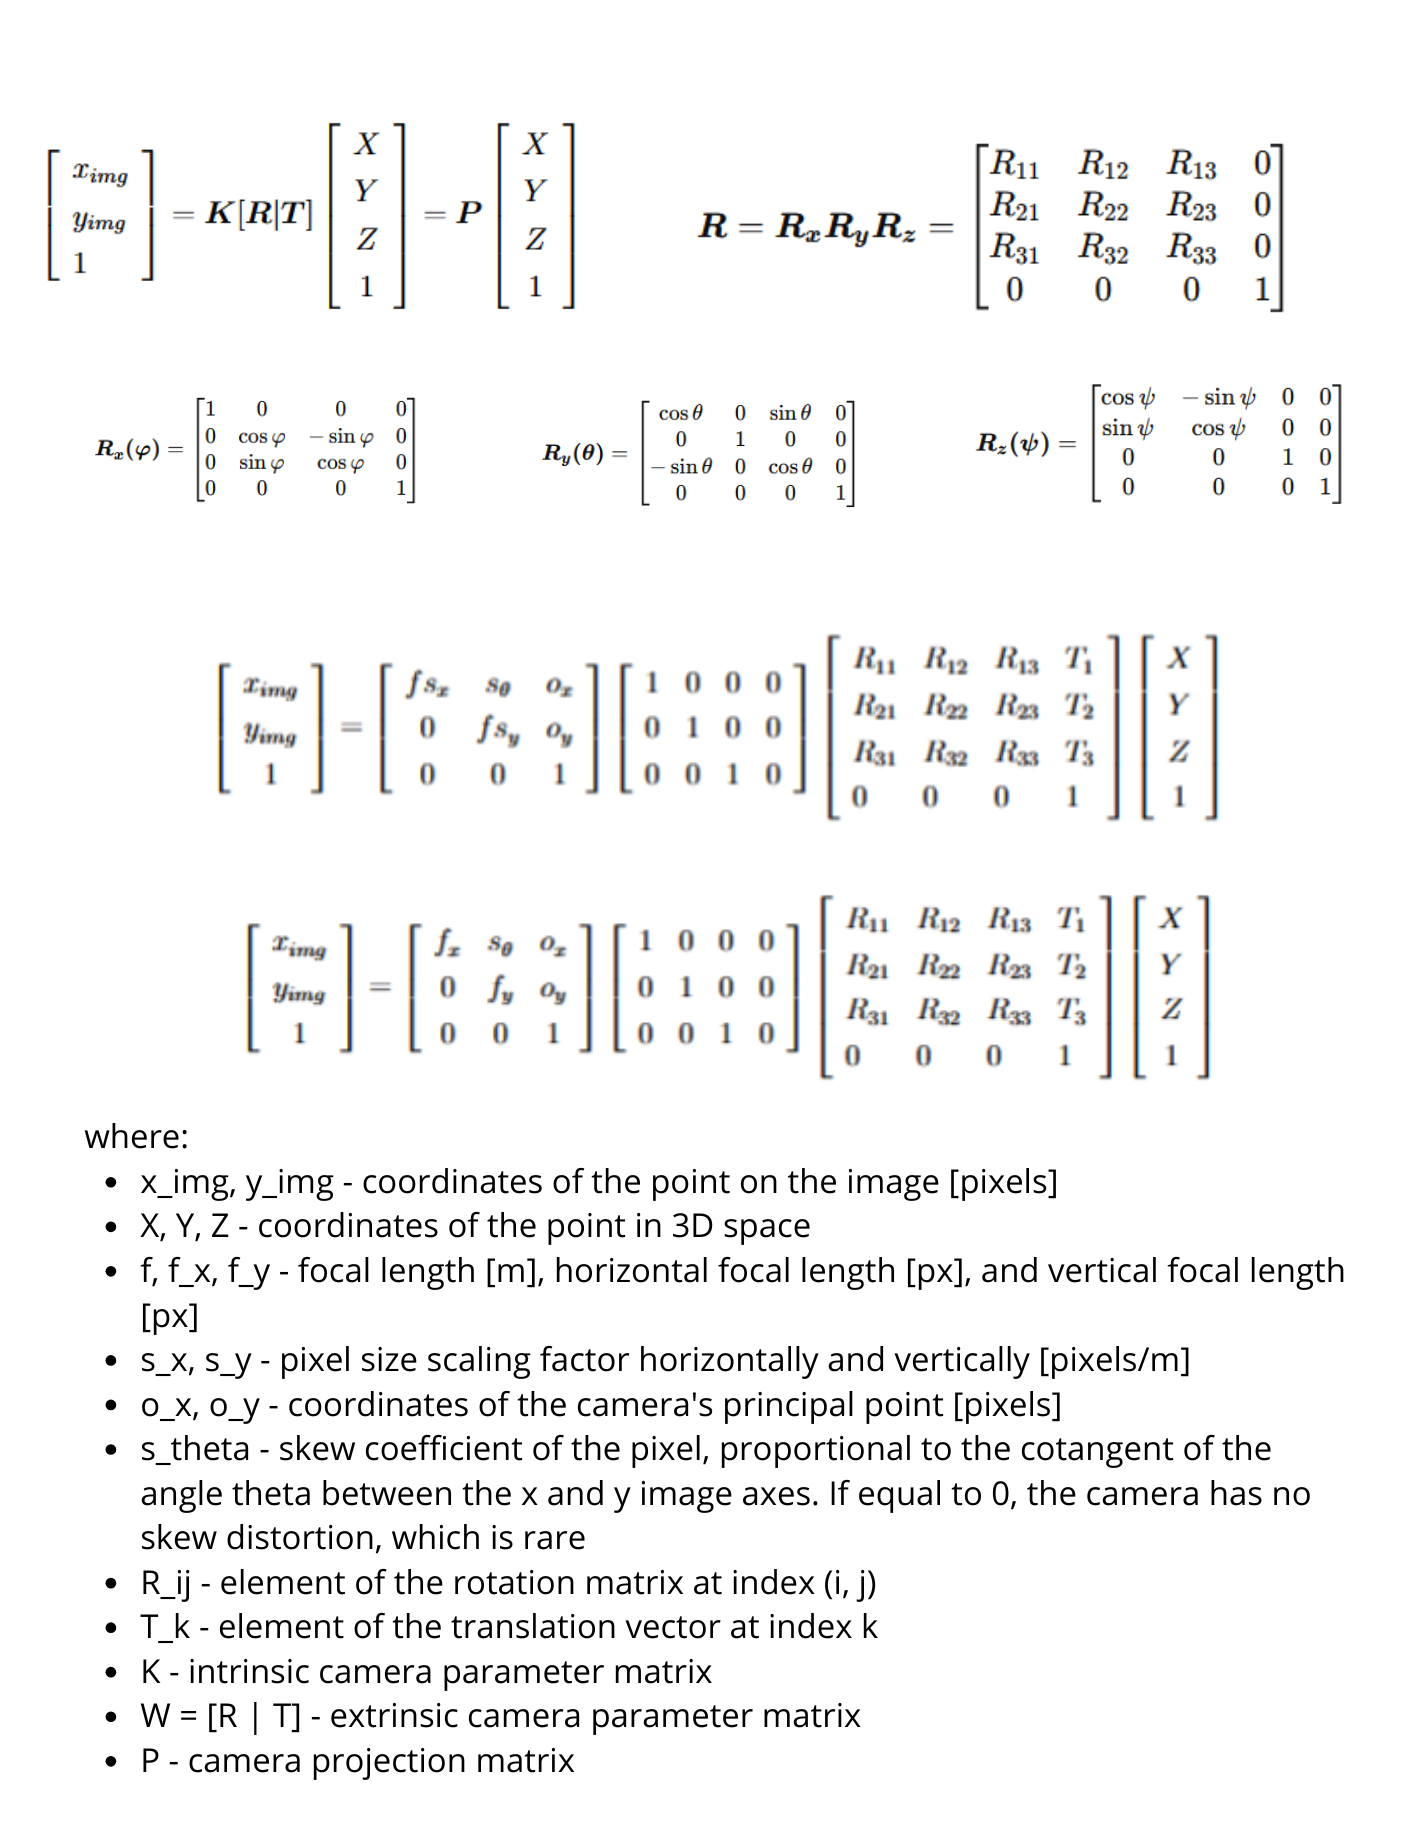

In [15]:
Image(filename=".././images/2_1.png", width=600)

### Współrzędne jednorodne - homogeus coordinates

W trakcie obliczeń zwykłe współrzędne zamienia się na współrzędne jednorodne, ponieważ ułątwiają one reprezentację oraz obliczenia transformacji geometrycznych, zwłaszcza perspektywicznych. Dzięki temu macierze mają spójne wymiary i możliwe jest wykonywanie obliczeń macierzowych np. mnożeń itd.

W praktyce polega to na dodaniu dodatkowego wymiaru do standaerdowych współrzędnych kartezjańskich. Dodatkową zaletą jest tworzenie puktów w nieskończoności - ich ostatnia współrzędna jest równa 0. 

Jeśli chcemy powrócić do współrzędnych kartezjańskich wystarczy podzielić wszystkie współrzędne przez ostatnią. 

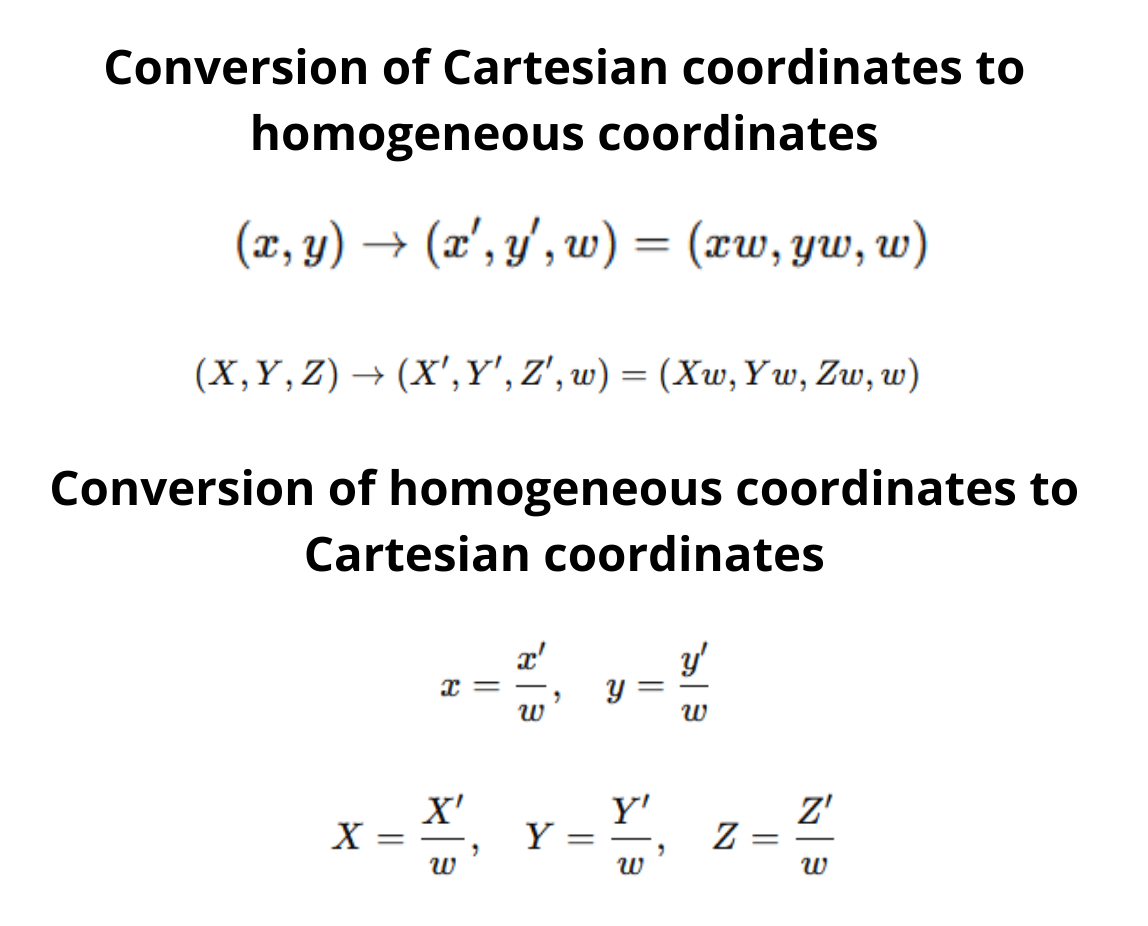

In [10]:
# source: https://pvphan.com/camera-calibration-1 
Image(filename=".././images/2_2.png", width=400)

### Jak wygląda w praktyce wyznaczenie pozycji obiektu 3D na obrazie - krok po kroku?

Do wyznaczania pozycji 3D obiektu potrzebne są zarówno macierze parametrów wewnętrznych kamer, jak i macierze rotacji i translacji.   Macierz parametrów zewnętrznych [R | T] to złożenie macierzy rotacji i translacji, która konwertuje punkty z układu współrzędnych układu odniesienia świata (3D) do układu współrzędnych kamery (3D). Wyznaczona macierz parametrów wewnętrznych K danego urządzenia uwzględnia liniową transformację perspektywiczną oraz parametry fizyczne macierzy pikseli. W pierwszej kolejności zapewnia ona transformację z układu współrzędnych kamery (3D) do układu współrzędnych obrazu (2D), innymi słowy odpowiada za projekcie punktów 3D do na "znormalizowaną płaszczyznę kamery" gdzie z = 1 (dzielimy współrzędne x i y przez z). Następnie dzięki obliczonym współczynnikom zniekształcenia obraz jest odzniekształcany. W ostatnim kroku te przeprocesowane punkty 2D są rzutowane do układu współrzędnych pikseli (2D). 

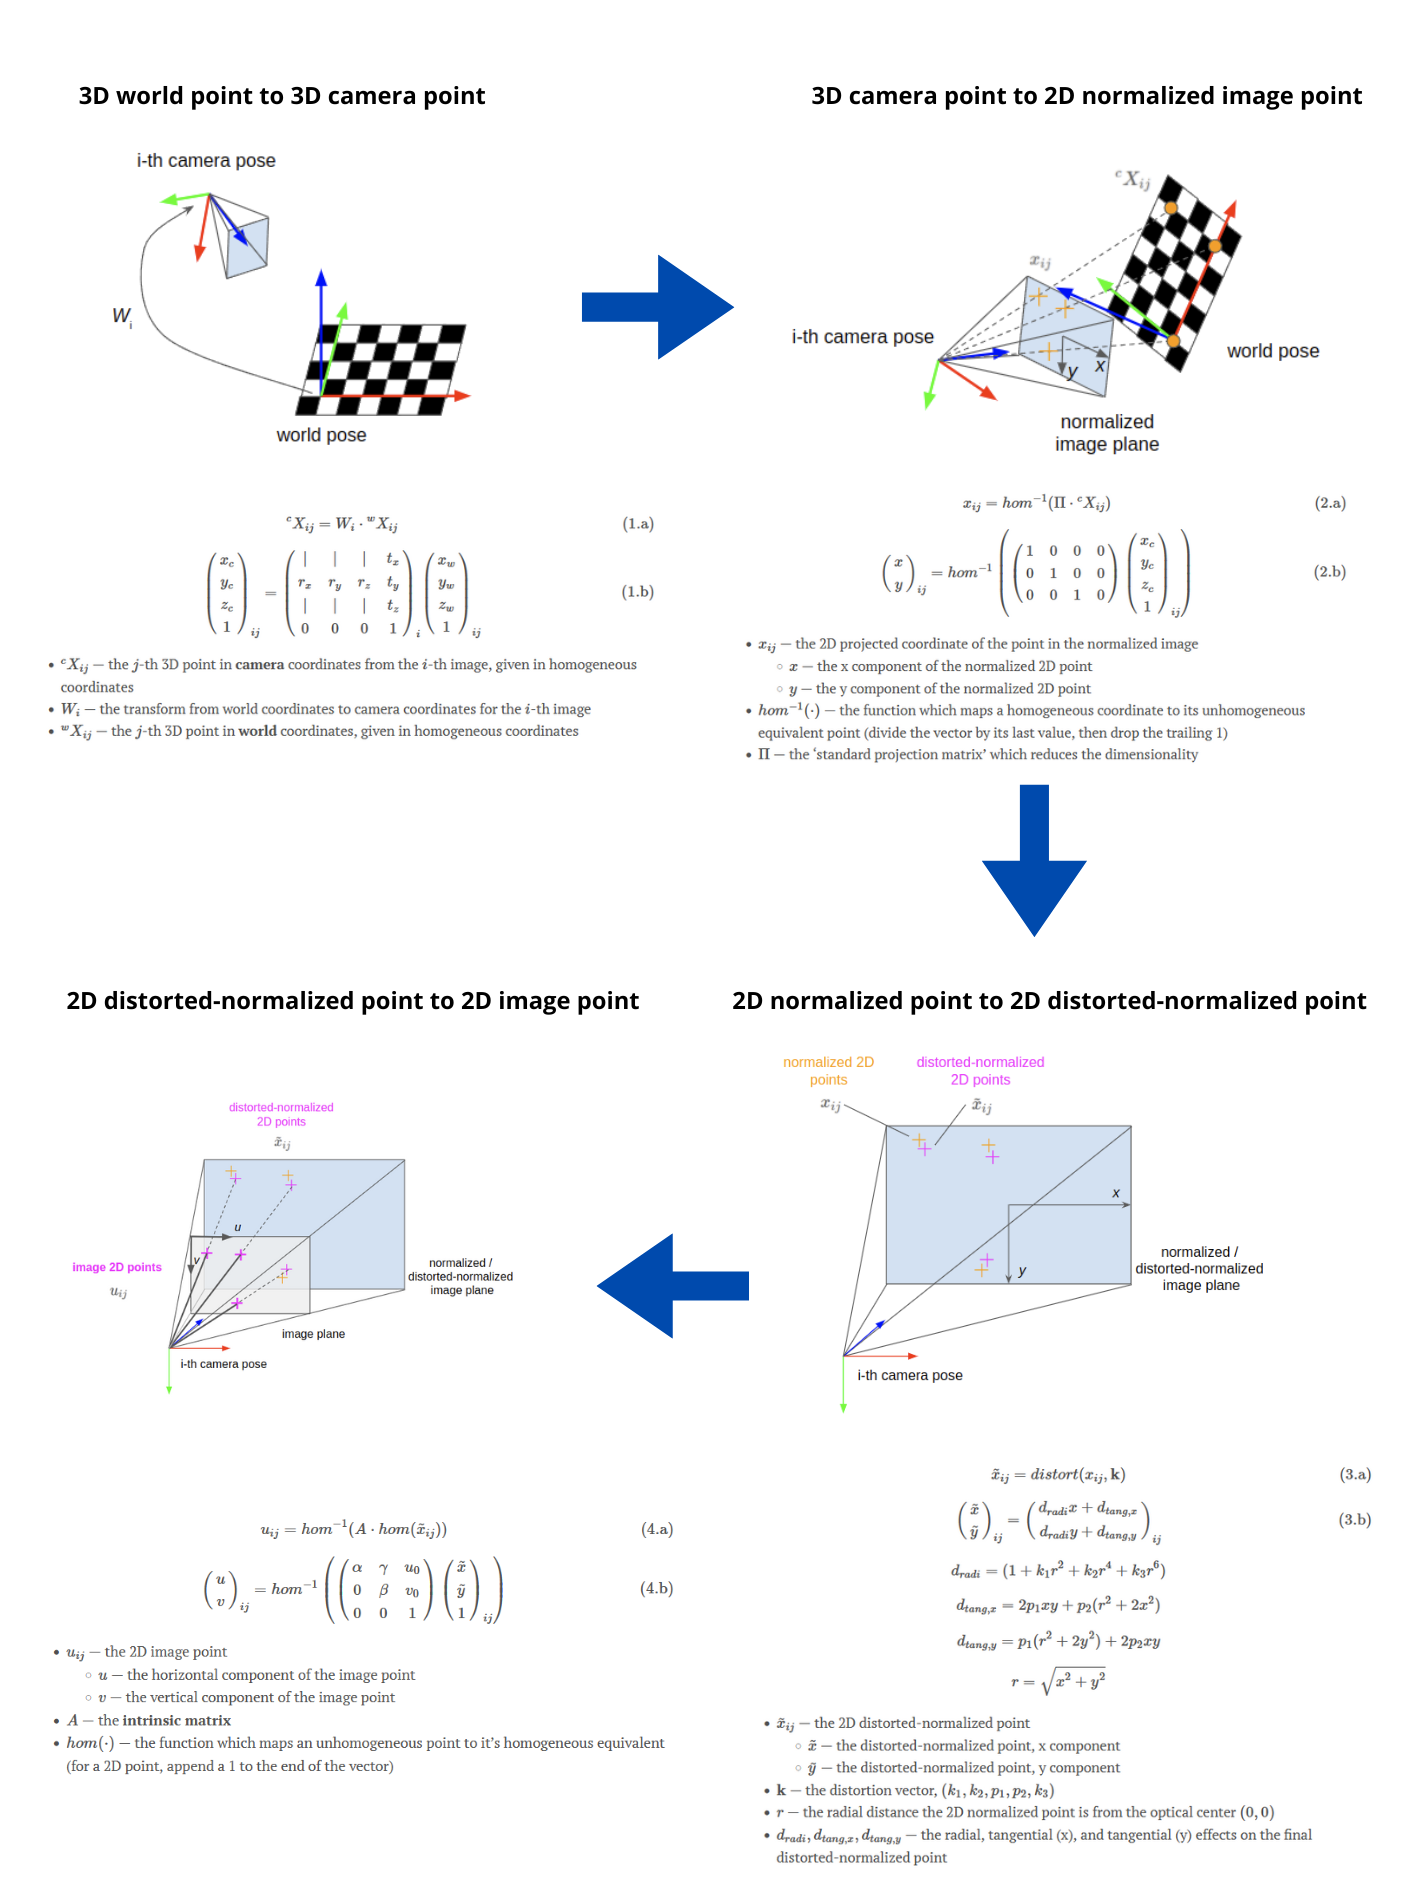

In [11]:
# source: https://pvphan.com/camera-calibration-1 
Image(filename=".././images/2_3.png", width=900)

### Jak wygląda procedura kalibracji?

Procedura składa się z kilku poniższych kroków:

- przygotowanie wzorca kalibracyjnego - najczęściej jest to szachownica lub szachownica z kodami aruco o znanych wymiarach rzeczywistych pól. Możesz ja wydrukować na zwykłym papierze. Dla poprawnego przebiegu kalibracji należy zadbać, żeby szachownica miała odpowiednie białe pole ochronne wokół, była wydrukowana na grubszym papierze matowym lub najlepiej twardej pokładce - żeby zadbać, że wszystkie punkty są współpłaszczyznowe. 
- zrobienie zdjęć kalibracyjnych - należy unieruchomieć kamerę oraz zrobić wiele zdjęć, najlepiej 13-17, przedstawiających pełny wzór szachownicy z różnych kątów i odległości.  Ważne, żeby szachownica nie była przycięta, bo algorytm nie będzie w stanie poprawnie wykryć narożników.
- detekcja narożników - jako, że szachownica jest znanych wzorcem możliwe jest wykrycie położenia narożników na obrazie 2D. Następnie w celu poprawy dokładności można zastosować metodę, która poprawia położenie tych narożników.
- obliczenie tych 11 nieznanych parametrów kalibracyjnych - w tym celu należy zastosować algorytm Zhang's opublikowany w 1998 roku, lub funkcję z biblioteki OpenCV. Danymi wejściowymi są: wykryte położenia narożników 2D oraz położenia narożników w 3D, w rzeczywistości na podstawie znanych wymiarów pola szachownicy (założenie, że środek układu współrzędnych jest w lewym, górnym narożniku szachownicy oraz, że wszystkie punkty szachownicy leżą na jednej płaszczyźnie. Osie układu współrzędnych są przyczepione do płaszczyzny szachownicy. Finalnie, współrzędne szachownicy można wyrazić kolejno jako, zakładając wymiary pola jako 0.05m x 0.05m((0,0,0), 0.05, 0, 0), (0.1, 0, 0), (0.15, 0, 0), (0.2, 0, 0); (0, -0.05,0) (0.05, - 0.05, 0), (0.1, - 0.05, 0), (0.15, - 0.05, 0), (0.2, 0 - 0.05, 0),) 
- ewaluacja wyników: sprawdzenie dokładności kalibracji poprzez obliczenie  sumy średniokwadratowego błędu projekcji. Innymi słowymi dzięki oblicoznym macierzom, każdy punkt 3D jest rzutowany na płaszczyznę obrazu 2D, a następnie obliczana jest suma kwadratów różnic między tymi punktami (odległość Euklidesowa). 

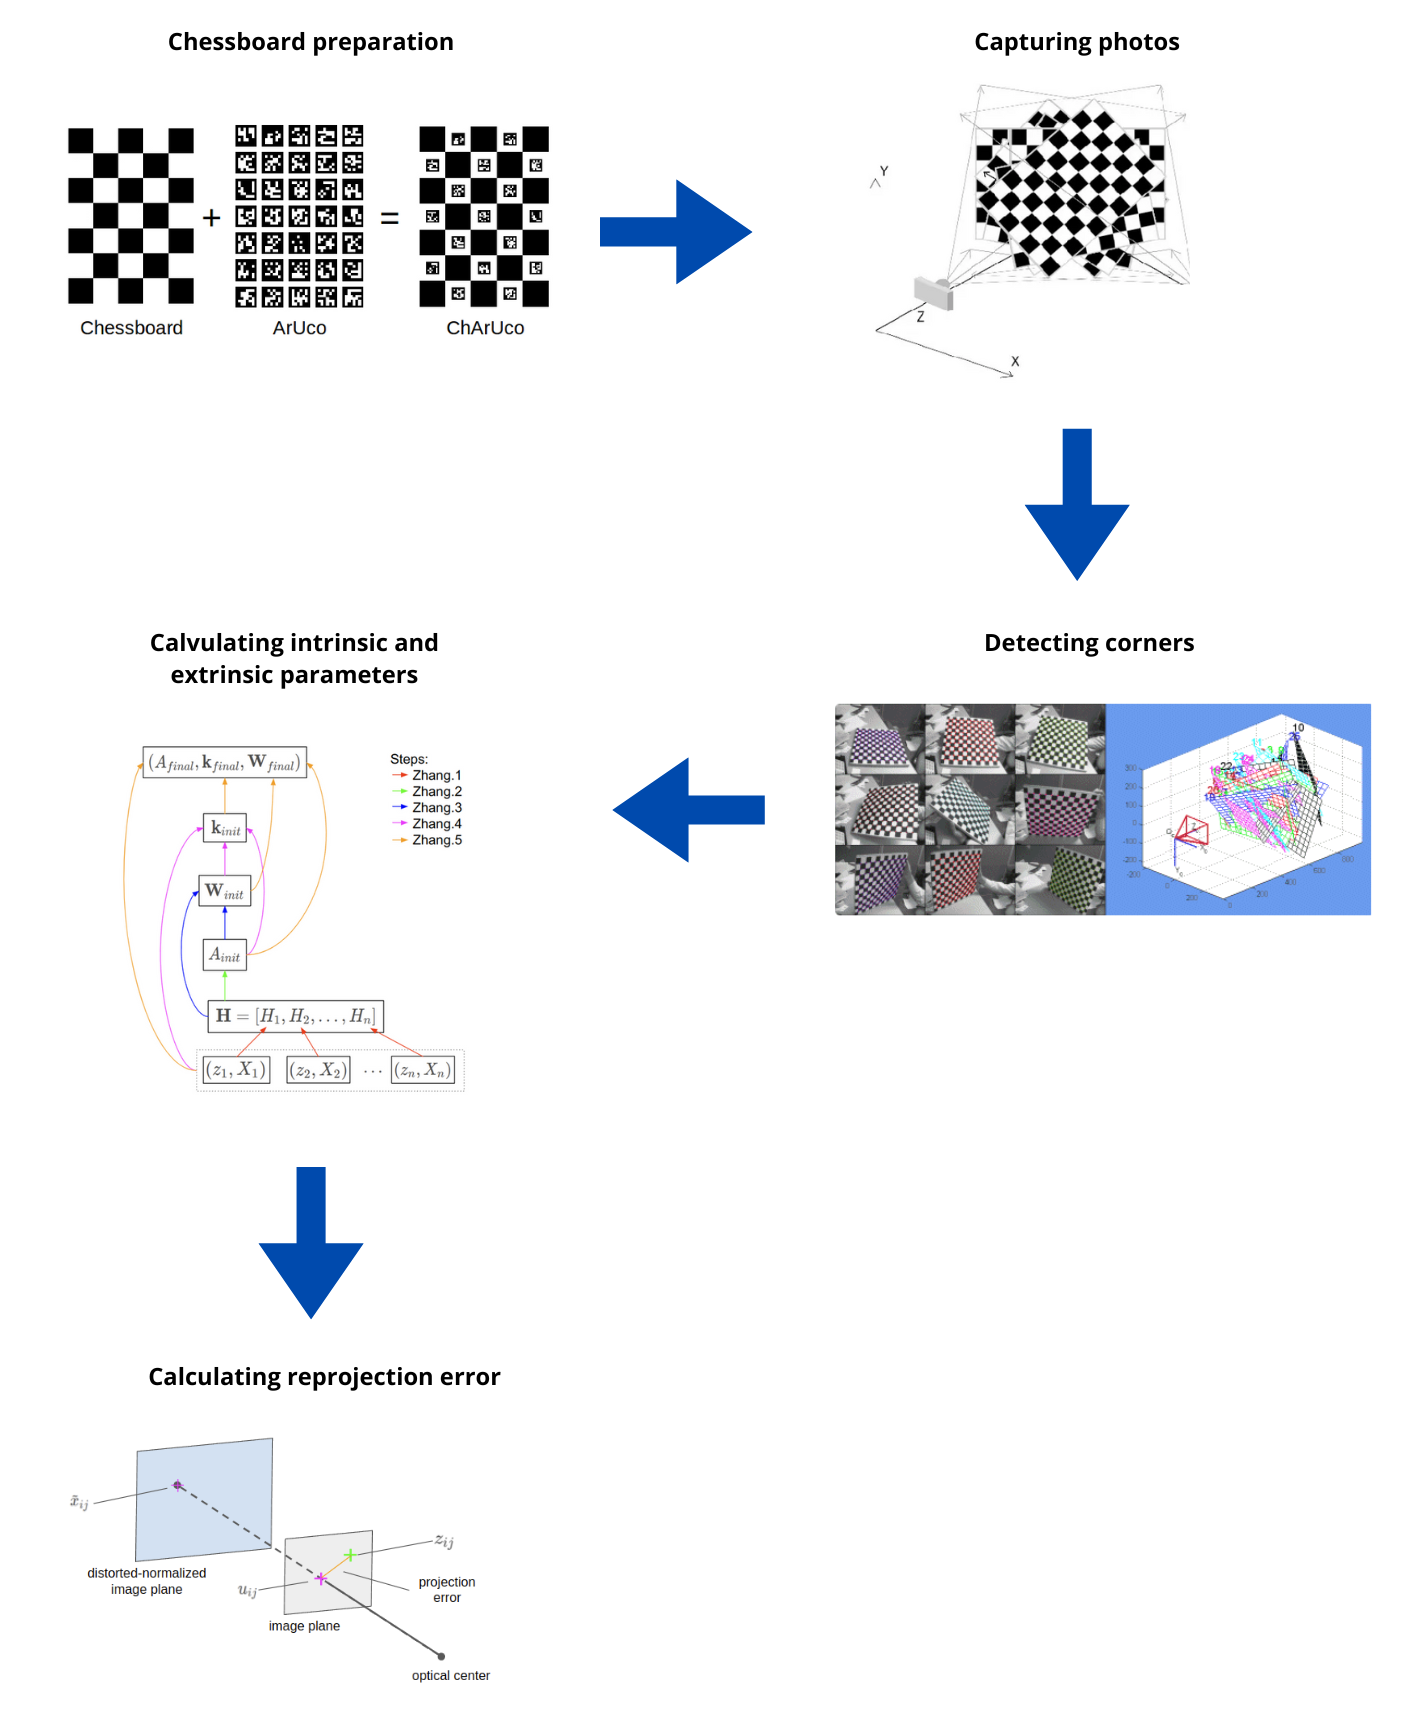

In [12]:
# source: https://farukalamai.medium.com/camera-calibration-explained-enhancing-accuracy-in-computer-vision-applications-8ad1494cc5f2,
#         https://pvphan.com/camera-calibration-1, https://pvphan.com/camera-calibration-2
Image(filename=".././images/2_4.png", width=600)

### Ale skąd się wzieły te macierze? czyli wyjaśnienie metody Zhanga

In [ ]:
# todo: dodać wyprowadzenie całe, ogarnać jak to się liczy

### Korekcja zniekształceń - skąd się wzięły wzory

O jakości uzyskanego obrazu decydują również zniekształcenia geometryczne wynikające z wad układu optycznego kamery. Objawiają się w postaci charakterystycznych zakrzywień obrazu, których natężenie wzrasta wraz ze wzrostem odległości punktu od osi optycznej kamery. Występujące deformacje mają głównie postać dystorsji radialnych, czyli zniekształceń poduszkowych lub beczkowych. Rzadziej spotykane są deformacje tangensialne, wynikające z faktu, że soczewka układu optycznego nie jest idealnie równoległa do płaszczyzny obrazu. Dokładnie to zostało przedstawione w notatniku 1_image_distortions. 

Zniekształcenia te mogą być opisane z wykorzystaniem współczynników dystorsji, na podstawie których możliwa jest korekcja współrzędnych danego punktu na obrazie - co można zaobserwować na schemacie jako 3 etap transformacji punktu 3D do 2D. Zniekształcenia te powodują, że nasz punkt docelowy P1 znajduje się w punkcie P2. W idealnym przypadku (po usunięciu zniekształceń) dążymy do tego, aby odległość (r) między punktami była równa 0, czyli punkty występowały w tym samym miejscu. 

W ogólnym przypadku korekcja zniekształceń polega na tym, że najpierw usuwane są zniekształcenia radialne, a następnie tangensialne.

Ale skąd wynikają powyższe wzory?
